In [1]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [2]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [3]:
# Selected Features
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']

# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.shape

(3619, 30)

# Load models

In [4]:
# Decision Tree
decision_tree = DecisionTreeRegressor(**load_params('saved_models/decision_tree_params.json'))

# Bagging
bagging = BaggingRegressor(**load_params('saved_models/bagging_params.json'))

# Random Forest
random_forest = RandomForestRegressor(**load_params('saved_models/random_forest_params.json'))

# Extremely randomized tree
extra_forest = ExtraTreesRegressor(**load_params('saved_models/extremely_randomized_forest_params.json'))

# Adaboost
adaboost = AdaBoostRegressor(**load_params('saved_models/adaboost_params.json'))

# sklearn gradient boosting
sk_gb = GradientBoostingRegressor(**load_params('saved_models/sk_gradient_boosting_params.json'))

# sklearn hist gradient boosting
hist_sk_gb = HistGradientBoostingRegressor(**load_params('saved_models/sk_hist_gradient_boosting_params.json'))

# lgbm
lgbm = LGBMRegressor(**load_params('saved_models/lgbm_params.json'))

# XGBOOST
xgb = xg.XGBRegressor(**load_params('saved_models/xgb_params.json'))

# Our own Stacking algorithm

We coded our own stacking algorithm and compared it with scikit learn's model, and achieved better performance in less time.

We figured that keeping the initial features in the last step metamodel gave even better performance (The Best over all our attempts).

We kept a simple architecture with a final linear regression and we only stack :
- XGBOOST
- LGBM
- Extremely Randomized Forest
- Random Forest

In [7]:
start = time.time()
estimators = [ ('xgb',xgb),('lgbm', lgbm),('extra_forest', extra_forest),('random_forest', random_forest)]
y_pred = stacking_prediction(estimators,X_train_np,y_train_np,X_test_np)
print(time.time()-start)

418.5899705886841


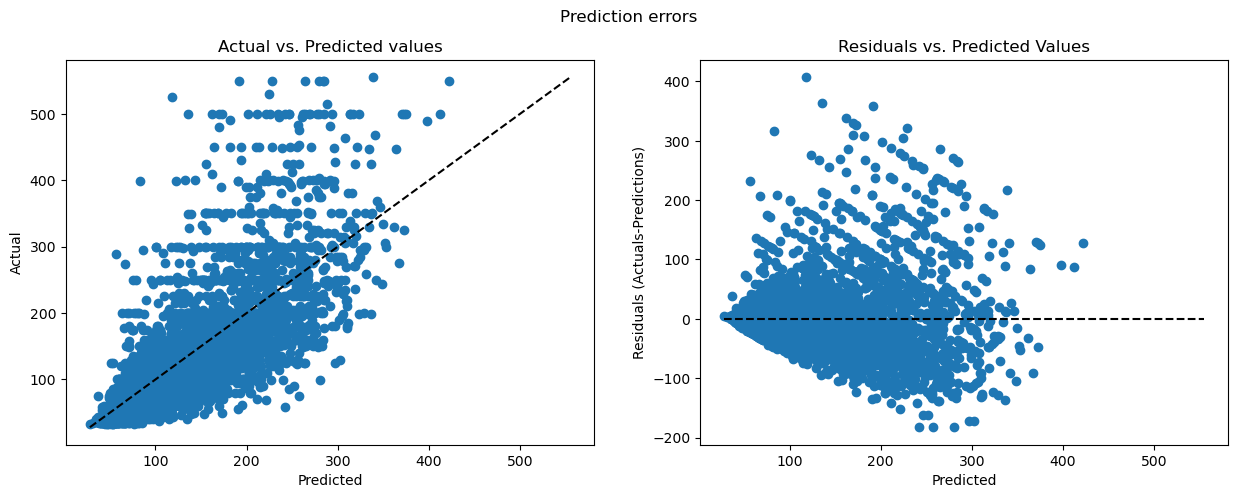

R²: 0.574005685903686
MAE: 40.40949897945306
MSE: 3811.056886482252
RMSE: 61.733758078398665
MAPE: 0.31209301850892385
error_ratio_rmse: 0.4463451028799277
error_ratio_mae: 0.2921672443204379


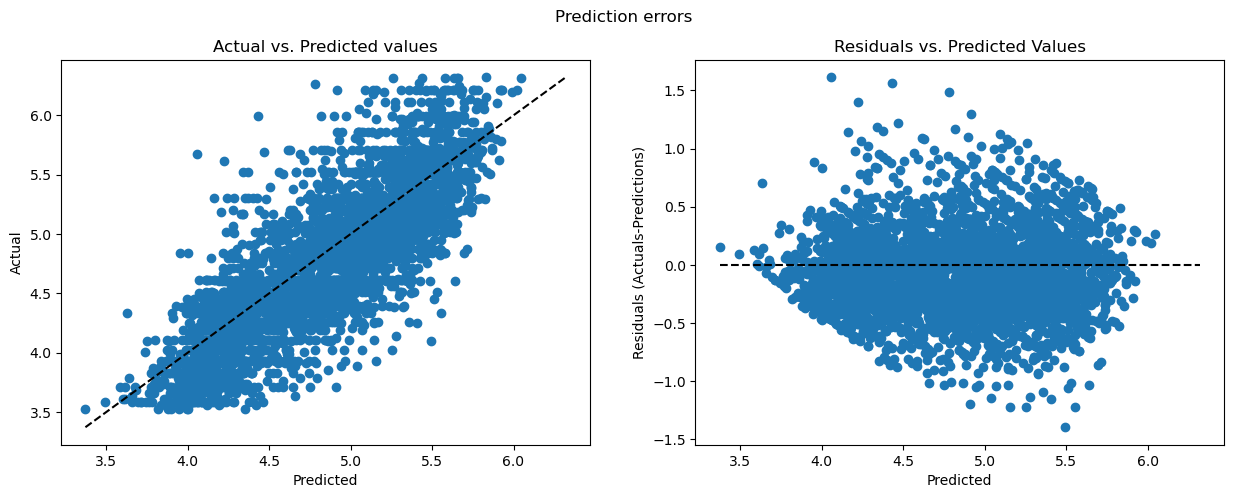

R²: 0.6633281891155715
MAE: 0.2811809945330845
MSE: 0.13084089298120127
RMSE: 0.36171935665817123
MAPE: 0.06037570852748997
error_ratio_rmse: 0.07634226456561428
error_ratio_mae: 0.0593443327827017


In [8]:
# score for price
homemade_stacking_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
homemade_stacking_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

# Comparison with scikit learn's Stacking

Our algorithm obtains better results and is 10 seconds faster.

Note that a key difference is that we kept the initial features on top of the meta features for the linear regression computation in the homemade version.

454.811794757843


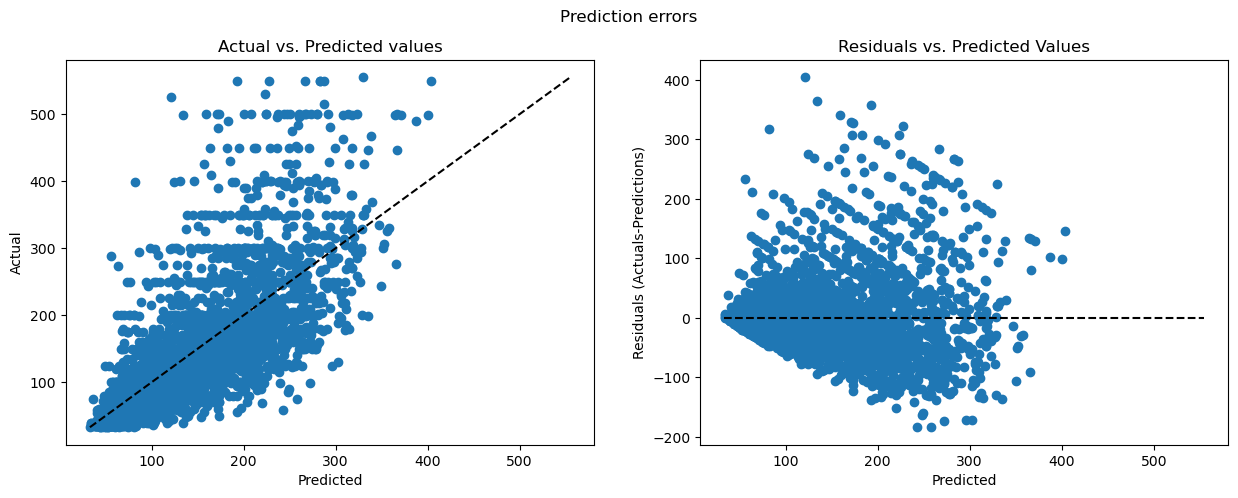

R²: 0.5735826433803399
MAE: 40.402963545648724
MSE: 3814.841535874329
RMSE: 61.764403468942604
MAPE: 0.3104257913374024
error_ratio_rmse: 0.44656667403355416
error_ratio_mae: 0.2921199920719994


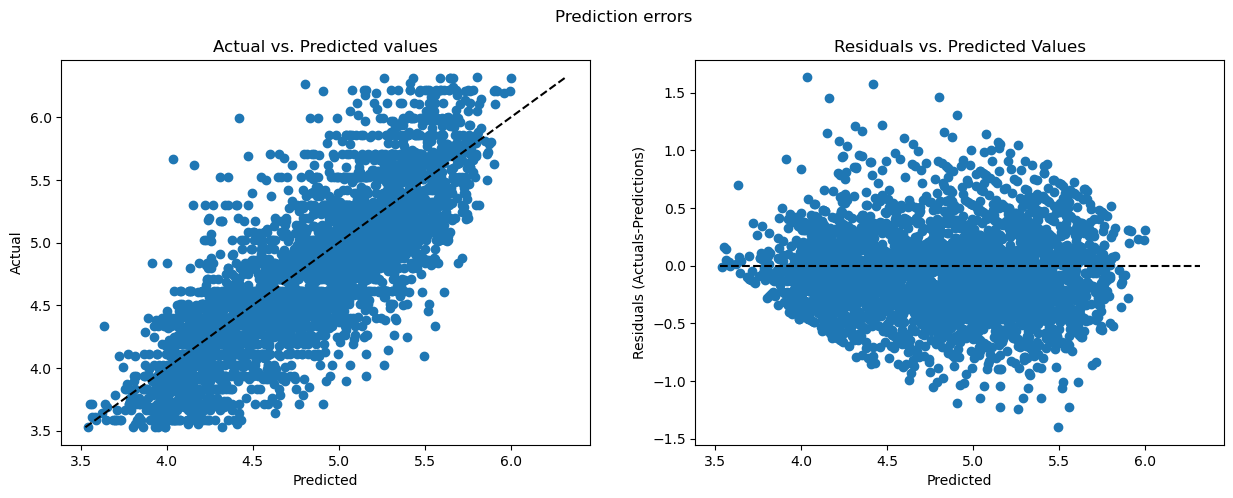

R²: 0.6643608340424014
MAE: 0.28043029734606617
MSE: 0.13043957579339152
RMSE: 0.36116419506007447
MAPE: 0.060121581615118116
error_ratio_rmse: 0.07622509557031878
error_ratio_mae: 0.059185895247620676


In [6]:
start = time.time()

#estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]
estimators = [ ('lgbm', lgbm),('extra_forest', extra_forest)]
estimators = [ ('xgb',xgb),('lgbm', lgbm),('extra_forest', extra_forest),('random_forest', random_forest)]

stacking = StackingRegressor(estimators=estimators, final_estimator = LinearRegression()).fit(X_train_np, y_train_np)

y_pred = np.maximum(0,stacking.predict(X_test_np))

print(time.time()-start)

# score for price
sk_stacking_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
sk_stacking_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

# Scores

In [10]:
# Homemade stacking

# Save the parameters as a JSON file
with open('saved_scores/homemade_stacking_scores.json', 'w') as f:
    json.dump(homemade_stacking_score, f)


# Save the parameters as a JSON file
with open('saved_scores/sk_stacking_scores.json', 'w') as f:
    json.dump(sk_stacking_score, f)